In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [2]:
def load_all(fname):
    return pickle.load(open(fname,"rb"))
def load_y(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
#path = "D:/SML Dataset/"
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000 
#n_trainSamples = [100,250,500,750,1000,1250,1500]
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train_all = load_all(path+"X_train_all_90.pkl")[:trainSamples]
X_val_all = load_all(path+"X_val_all_90.pkl")

y_train = load_y(path+"y_train.p")[:trainSamples]
y_val = load_y(path+"y_val.p")

In [5]:
import lightgbm as lgb

In [6]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [100,150],
    'learning_rate': [0.05,0.1,0.15]
}

In [9]:
clf = GridSearchCV(lgb.LGBMClassifier(boosting_type='gbdt', objective='binary',  min_child_weight=0.001, min_child_samples=20, colsample_bytree=1.0, n_jobs=-1, importance_type='split'), 
                      parameters,n_jobs=1, verbose=4, iid=True, cv=5)

In [10]:
gridtime = time.time()
model = clf.fit(X_train_all, y_train)
print("The Total Training Time Taken : ",time.time() - gridtime)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_estimators=100, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, learning_rate=0.05, score=0.7804, total= 1.5min
[CV] n_estimators=100, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.05, score=0.7754, total= 1.4min
[CV] n_estimators=100, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.05, score=0.7934666666666667, total= 1.4min
[CV] n_estimators=100, learning_rate=0.05 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.5min remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.05, score=0.8117333333333333, total= 1.5min
[CV] n_estimators=100, learning_rate=0.05 ............................
[CV]  n_estimators=100, learning_rate=0.05, score=0.7905333333333333, total= 1.5min
[CV] n_estimators=150, learning_rate=0.05 ............................
[CV]  n_estimators=150, learning_rate=0.05, score=0.7948, total= 1.9min
[CV] n_estimators=150, learning_rate=0.05 ............................
[CV]  n_estimators=150, learning_rate=0.05, score=0.791, total= 1.9min
[CV] n_estimators=150, learning_rate=0.05 ............................
[CV]  n_estimators=150, learning_rate=0.05, score=0.8028, total= 1.8min
[CV] n_estimators=150, learning_rate=0.05 ............................
[CV]  n_estimators=150, learning_rate=0.05, score=0.8162666666666667, total= 1.8min
[CV] n_estimators=150, learning_rate=0.05 ............................
[CV]  n_estimators=150, learning_rate=0.05, score=0.8046, total= 1.9min
[CV] n_estimators=100, learning_rat

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 49.7min finished


The Total Training Time Taken :  3116.893205165863


In [11]:
model.best_score_

0.8045866666666667

In [12]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'n_estimators': 150, 'learning_rate': 0.1}
learning_rate: 0.1
n_estimators: 150


In [13]:
pickle.dump(model,open("LGBMClassifier_all_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [14]:
X_test_all = load_all(path+"X_test_all_90.pkl")
y_test = load_y(path+"y_test.p")

In [15]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=model.best_params_['n_estimators'], 
                                   learning_rate=model.best_params_['learning_rate'], objective='binary',  
                                   min_child_weight=0.001, min_child_samples=20, colsample_bytree=1.0, n_jobs=-1, 
                                   silent=True, importance_type='split')

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    bestModel.fit(X_train_all[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_val = bestModel.predict(X_val_all)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    preds_test = bestModel.predict(X_test_all)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_all)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
Train Time:0.45 sec
Validation Accuracy: 50.07%
Validation Time:0.11 sec
Test Accuracy: 50.03%
Test Time:0.10 sec
(0.418381481481482, 0.17466666666666666, 0.5146666666666667)
MRR: 0.418381481481482
MRR Time:0.84 sec
SampleSize: 500
Train Time:6.52 sec
Validation Accuracy: 49.97%
Validation Time:0.10 sec
Test Accuracy: 50.02%
Test Time:0.12 sec
(0.4177238095238094, 0.176, 0.5113333333333333)
MRR: 0.4177238095238094
MRR Time:0.58 sec
SampleSize: 1000
Train Time:19.36 sec
Validation Accuracy: 49.93%
Validation Time:0.11 sec
Test Accuracy: 50.03%
Test Time:0.11 sec
(0.41894444444444495, 0.17666666666666667, 0.5206666666666667)
MRR: 0.41894444444444495
MRR Time:0.58 sec
SampleSize: 10000
Train Time:44.24 sec
Validation Accuracy: 50.19%
Validation Time:0.11 sec
Test Accuracy: 50.06%
Test Time:0.33 sec
(0.4445545454545463, 0.20666666666666667, 0.56)
MRR: 0.4445545454545463
MRR Time:0.95 sec
SampleSize: 20000
Train Time:56.48 sec
Validation Accuracy: 50.95%
Validation Time:0.10

In [18]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("LGBMClassifier_Accuracy_all.png")
    #plt.show()

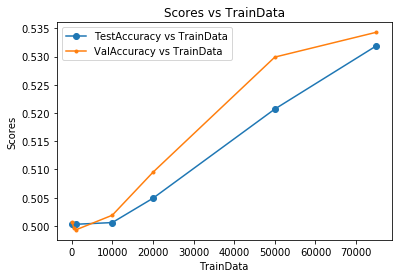

In [19]:
accuracyVisualization()

In [20]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("LGBMClassifier_Mrr_all.png")
    plt.show()

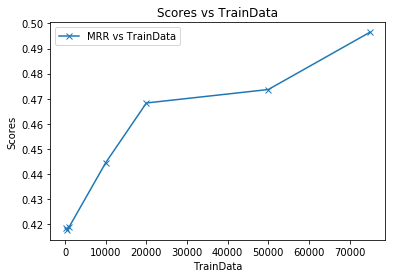

In [21]:
mrrVisualization()

In [22]:
#Precision @1 and Precision @2 Visualizations
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("LGBM_Precision_all.png")
    plt.show()

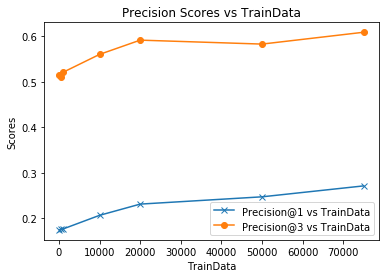

In [23]:
precisionVisualization()